<a href="https://colab.research.google.com/github/kasprova/advanced_customer_analytics/blob/master/notebooks/survival_analysis_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### R setup

In [0]:
#extension to load R and Python together
%load_ext rpy2.ipython

%%R
library(survival)

###Libraries and connections

In [0]:
!pip install pandas==0.24.0
!pip install scikit-survival
!pip install lifelines

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
plt.style.use('default')
plt.rcParams["figure.figsize"] = (5,2)

In [0]:
from sklearn.model_selection import train_test_split 

In [2]:
pd.__version__

'0.24.0'

In [3]:
#load data
#mount google drive to get access to the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset manipulations

In [0]:
!unzip -q "drive/My Drive/analytics/survival_features_parquet_20191202.zip"

In [0]:
data_pd = pd.read_parquet('survival_features_20191202.parquet')
#data_pd = data_pd[data_pd["last_purchase"]<"2017-10-01"]
data_pd['duration'] = data_pd['duration']+1
data_pd = data_pd.fillna(0)
data_pd['churn'] = data_pd['churn'].astype(bool)

In [0]:
#subsample
temp = data_pd[["household_id"]].sample(n=5000, random_state = 42)
df = pd.merge(data_pd,temp,left_on=['household_id'],right_on=['household_id'], how='inner')

In [0]:
#copy dataset
data  = df.copy()
#select features for cpx
x_select = ['duration', 'churn', 'monetary', 'mean_check', 'sd_check']
#split on test and train
cph_train, cph_test = train_test_split(data[x_select], test_size=0.2, random_state = 42)

In [346]:
 cph_train.head(5)

,duration,churn,monetary,mean_check,sd_check
4227,775,False,1297.46,5.98,3.07
4676,622,True,57.69,3.39,4.05
800,779,False,8118.03,5.22,4.85
3671,778,False,1711.58,6.32,6.54
4193,1,True,90.07,4.09,2.34


In [347]:
cph_test.head(5)

,duration,churn,monetary,mean_check,sd_check
1501,800,False,4303.80,3.58,2.38
2586,1,True,42.29,2.64,2.43
2653,758,True,649.34,2.94,2.12
1055,656,False,20643.50,5.04,7.37
705,701,True,1876.74,2.97,2.68


## Kaplan-Meier

In [0]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 

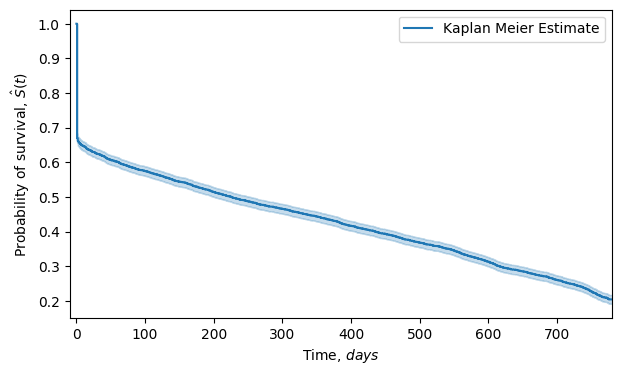

In [396]:
kmf = KaplanMeierFitter() 
kmf.fit(df['duration'], df['churn'].astype(bool),label='Kaplan Meier Estimate')
kmf.plot(ci_show=True, figsize = (7,4))
plt.ylabel("Probability of survival, $\hat{S}(t)$")
plt.xlabel("Time, $days$")
plt.xlim([-10, 780]) 
#plt.title("Kaplan-Meier: from first purchase (in 2 years data)  to churn")
plt.show()

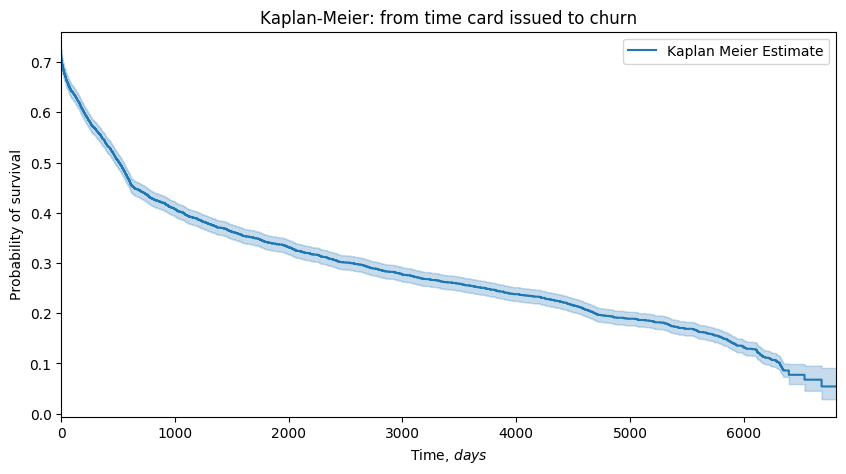

In [391]:
kmf = KaplanMeierFitter() 
kmf.fit(df['days_since_card'], df['churn'].astype(bool),label='Kaplan Meier Estimate')
kmf.plot(ci_show=True)
plt.ylabel("Probability of survival")
plt.xlabel("Time, $days$")
plt.title("Kaplan-Meier: from time card issued to churn")
plt.show()

## Cox Proportional Hazard Model

In [0]:
from lifelines import CoxPHFitter

In [376]:
cph_train.columns

Index(['duration', 'churn', 'monetary', 'mean_check', 'sd_check'], dtype='object')

In [0]:
cph = CoxPHFitter()
cph.fit(cph_train, 'duration', event_col='churn', show_progress=True, step_size = 0.1) 


In [378]:
cph.print_summary() 

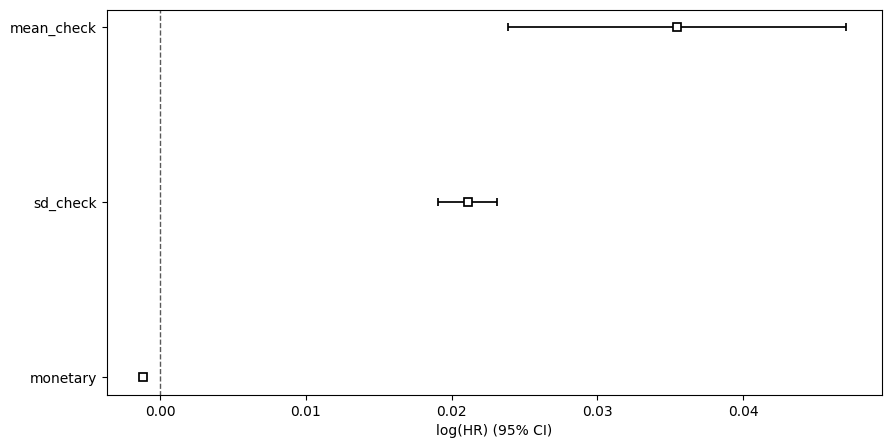

In [379]:
cph.plot()

In [0]:
censored_subjects = cph_train.loc[cph_train['churn']==0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[data.loc[c.name, 'duration']]).clip(upper=1)) 

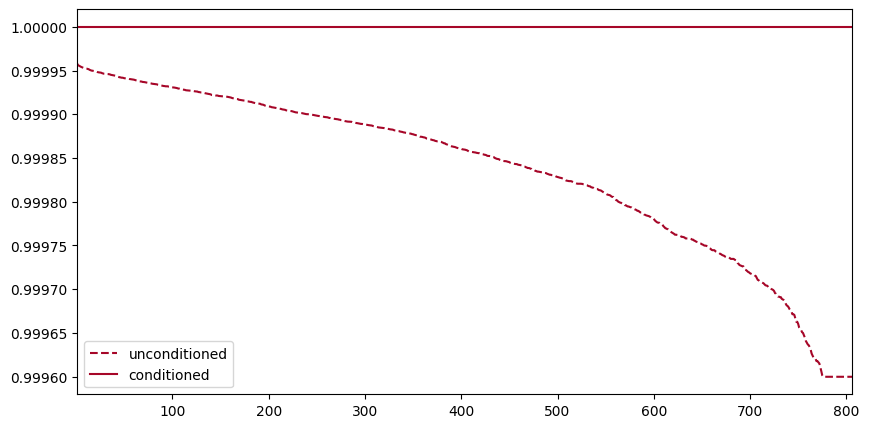

In [381]:
subject = 800
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned") 
conditioned_sf[subject].plot(color="#A60628", label="conditioned") 
plt.legend()

In [0]:
#Estimating event time
from lifelines.utils import median_survival_times, qth_survival_times

predictions_50 = median_survival_times(conditioned_sf)
predictions_80 = qth_survival_times(0.8, conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

data['avg_value_day'] = data['monetary']/data['duration']

In [383]:
values = predictions_80.T.join(data[['avg_value_day','duration']])
#value a customer bring in the future with 80% probability to survive
values['remaining_value_80'] = values['avg_value_day'] * (values[0.8] - values['duration'])
#estimated number of days he stays with our store (future) with probability to 
values['remaining_days_80'] =  values[0.8] - values['duration']
values.tail()

,0.8,avg_value_day,duration,remaining_value_80,remaining_days_80
1685,132.0,4.447857,28,462.577143,104.0
2919,752.0,0.078194,742,0.781941,10.0
4426,764.0,1.886977,698,124.540487,66.0
3092,inf,5.321494,790,inf,inf
3772,inf,2.071001,789,inf,inf


In [385]:
values.loc[1743]

0.8                   230.000000
avg_value_day           0.536029
duration              136.000000
remaining_value_80     50.386765
remaining_days_80      94.000000
Name: 1743, dtype: float64

In [238]:
values = predictions_50.T.join(data[['avg_value_day','duration']])
#value a customer bring in the future with 80% probability to survive
values['remaining_value_50'] = values['avg_value_day'] * (values[0.5] - values['duration'])
#estimated number of days he stays with our store (future) with probability to 
values['remaining_days_50'] =  values[0.5] - values['duration']
values.tail()

,0.5,avg_value_day,duration,remaining_value_50,remaining_days_50
1685,342.0,4.447857,28,1396.627143,314.0
2919,773.0,0.078194,742,2.424016,31.0
4426,inf,1.886977,698,inf,inf
3092,inf,5.321494,790,inf,inf
3772,inf,2.071001,789,inf,inf


In [239]:
values = predictions_75.T.join(data[['avg_value_day','duration']])
#value a customer bring in the future with 80% probability to survive
values['remaining_value_75'] = values['avg_value_day'] * (values[0.75] - values['duration'])
#estimated number of days he stays with our store (future) with probability to 
values['remaining_days_75'] =  values[0.75] - values['duration']
values.tail()

,0.75,avg_value_day,duration,remaining_value_75,remaining_days_75
1685,163.0,4.447857,28,600.460714,135.0
2919,756.0,0.078194,742,1.094717,14.0
4426,776.0,1.886977,698,147.184212,78.0
3092,inf,5.321494,790,inf,inf
3772,inf,2.071001,789,inf,inf


In [240]:
data.loc[87]

household_id                     115587154
last_purchase                   2015-11-25
first_purchase                  2015-11-25
duration                                 1
frequency                                1
monetary                            152.88
mean_check                            4.25
sd_check                              2.95
month_last_purchase                     11
year_purchase                         2015
mean_check2                          18.03
first_shop_date        2015-11-25 00:00:00
days_since_card                          0
churn                                 True
avg_value_day                       152.88
Name: 87, dtype: object

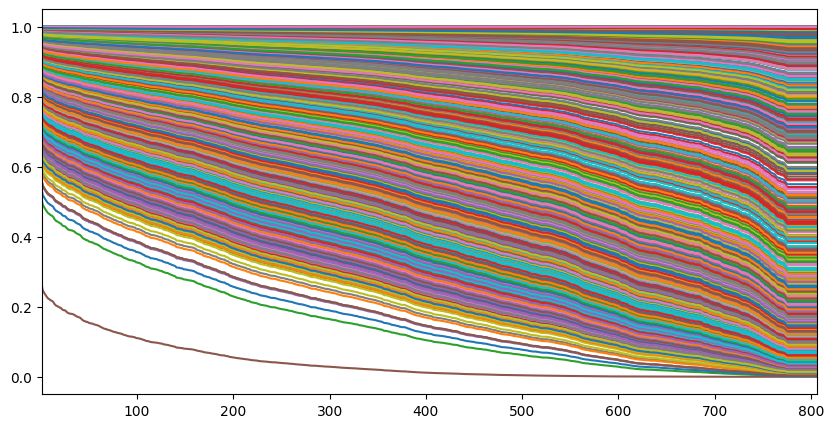

In [241]:
plt.rcParams["figure.figsize"] = (10,5)
cph.predict_survival_function(censored_subjects).plot(legend=False)

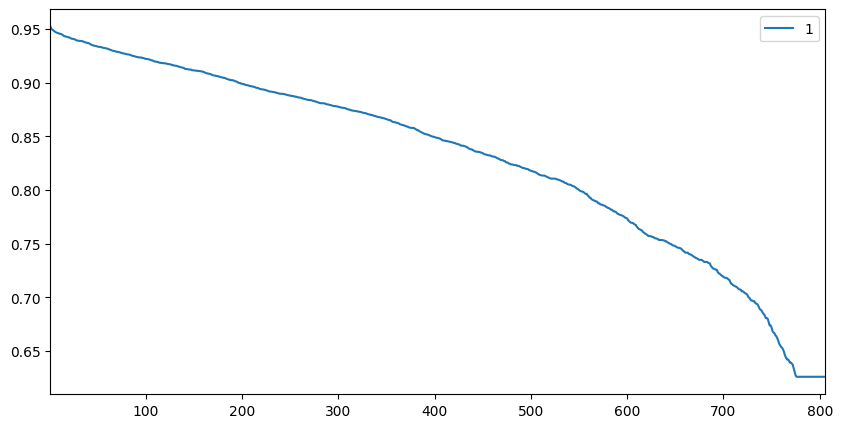

In [242]:
cph.predict_survival_function(censored_subjects.loc[1]).plot()

In [243]:
censored_subjects.loc[1]

duration          783
churn           False
monetary      1980.01
mean_check       4.16
sd_check         3.53
Name: 1, dtype: object

### Accuracy and Calibration

In [0]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

Text(0.5, 1.0, 'Calibration plots (reliability curve)')

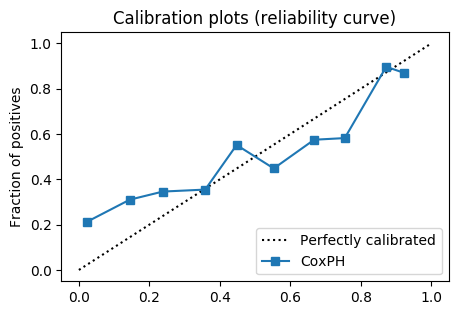

In [245]:
plt.figure(figsize=(5, 5))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated") 

probs = 1-np.array(cph.predict_survival_function(cph_test).loc[580])
actual = cph_test['churn']

fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins=10, normalize=False) 

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("CoxPH",)) 
ax1.set_ylabel("Fraction of positives") 
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve)')

In [246]:
brier_score_loss( 
    cph_test['churn'], #actual
    1-np.array(cph.predict_survival_function(cph_test).loc[180]), #prob
    pos_label=1 
)

0.2141062349550246

<Figure size 500x500 with 0 Axes>

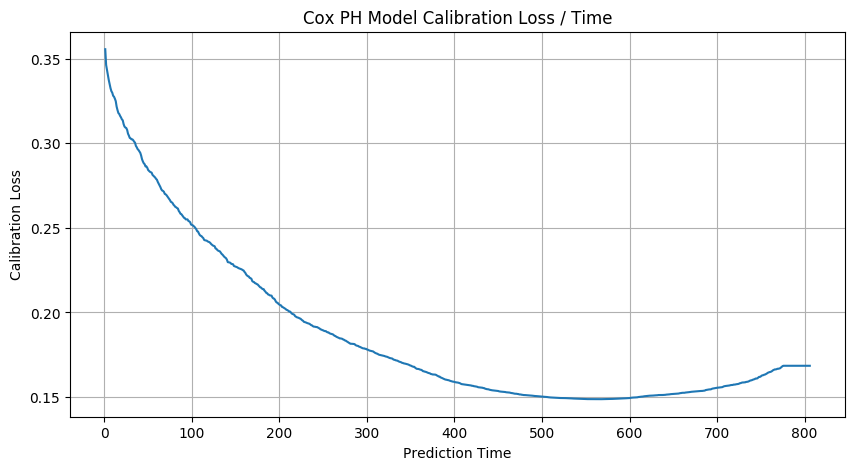

In [247]:
loss_dict = {} 
for i in cph.predict_survival_function(cph_test).index: 
    score = brier_score_loss( 
              cph_test['churn'], 1-np.array(cph.predict_survival_function(cph_test).loc[i]), pos_label=1 
          )
    loss_dict[i] = [score] 
loss_df = pd.DataFrame(loss_dict).T 

plt.figure(figsize=(5, 5))
fig, ax = plt.subplots() 
ax.plot(loss_df.index, loss_df) 
ax.set(xlabel='Prediction Time', ylabel='Calibration Loss', title='Cox PH Model Calibration Loss / Time') 
ax.grid() 

plt.show()

----------

### Normalized data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
#copy dataset
data  = df.copy()
#select features for cpx
x_select = ['monetary_log', 'mean_check', 'sd_check']


In [0]:
data[['monetary_log']] = np.log1p(data[['monetary']])
#applying StandardScaler scaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data[x_select])
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = x_select

scaled_features = []
for i in x_select:
  data["scaled_"+i] = scaled_df[i]
  scaled_features.append("scaled_"+i)

scaled_features.append('churn')
scaled_features.append('duration')

In [0]:
#split on test and train
cph_train, cph_test = train_test_split(data[scaled_features], test_size=0.2, random_state = 42)

In [361]:
cph_test

,scaled_monetary_log,scaled_mean_check,scaled_sd_check,churn,duration
1501,1.656597,-0.125714,-0.041279,False,800
2586,-0.684166,-0.454298,-0.039877,True,1
2653,0.694762,-0.349430,-0.048571,True,758
1055,2.454424,0.384641,0.098666,False,656
705,1.234374,-0.338944,-0.032866,True,701
106,-0.298418,-0.464784,-0.050814,True,518
589,-0.644926,0.077030,0.062768,True,3
2468,-0.545580,-0.401864,-0.062313,True,1
2413,-0.944405,-0.408855,0.035284,True,1
1600,1.000942,-0.153678,-0.046047,True,773


In [362]:
cph = CoxPHFitter()
cph.fit(cph_train, 'duration', event_col='churn', show_progress=True, step_size = 0.1) 

Iteration 1: norm_delta = 1.35214, step_size = 0.1000, ll = -22689.87269, newton_decrement = 1730.74325, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.19194, step_size = 0.1000, ll = -22361.07343, newton_decrement = 1394.30692, seconds_since_start = 0.3
Iteration 3: norm_delta = 1.06768, step_size = 0.1000, ll = -22096.15034, newton_decrement = 1132.97918, seconds_since_start = 0.4
Iteration 4: norm_delta = 0.94576, step_size = 0.1200, ll = -21840.50540, newton_decrement = 887.42678, seconds_since_start = 0.5
Iteration 5: norm_delta = 0.82325, step_size = 0.1440, ll = -21603.23203, newton_decrement = 663.44650, seconds_since_start = 0.6
Iteration 6: norm_delta = 0.69823, step_size = 0.1728, ll = -21393.60891, newton_decrement = 466.96980, seconds_since_start = 0.8
Iteration 7: norm_delta = 0.57082, step_size = 0.2074, ll = -21219.84672, newton_decrement = 303.78285, seconds_since_start = 0.9
Iteration 8: norm_delta = 0.44362, step_size = 0.2488, ll = -21087.29365, newton_decrem

<lifelines.CoxPHFitter: fitted with 4000 total observations, 1042 right-censored observations>

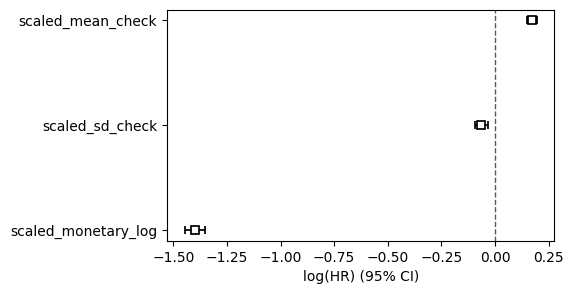

In [363]:
plt.rcParams["figure.figsize"] = (5,3)
cph.plot()

In [364]:
cph.print_summary() 

In [0]:
censored_subjects = cph_train.loc[cph_train['churn']==0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[data.loc[c.name, 'duration']]).clip(upper=1)) 

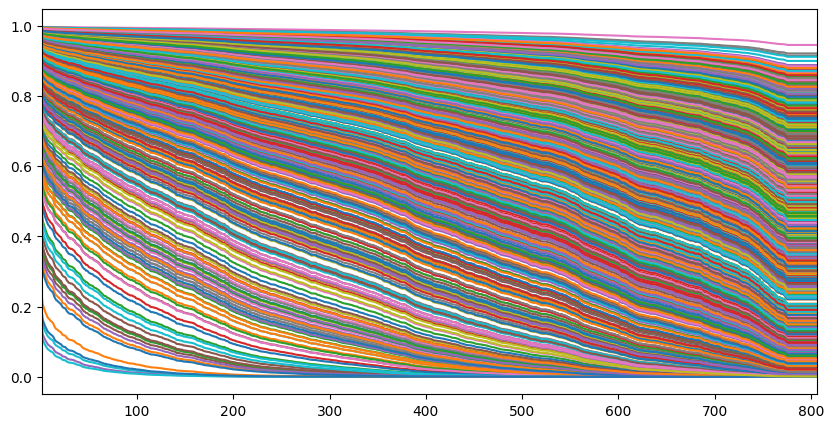

In [366]:
plt.rcParams["figure.figsize"] = (10,5)
cph.predict_survival_function(censored_subjects).plot(legend=False)

<Figure size 500x500 with 0 Axes>

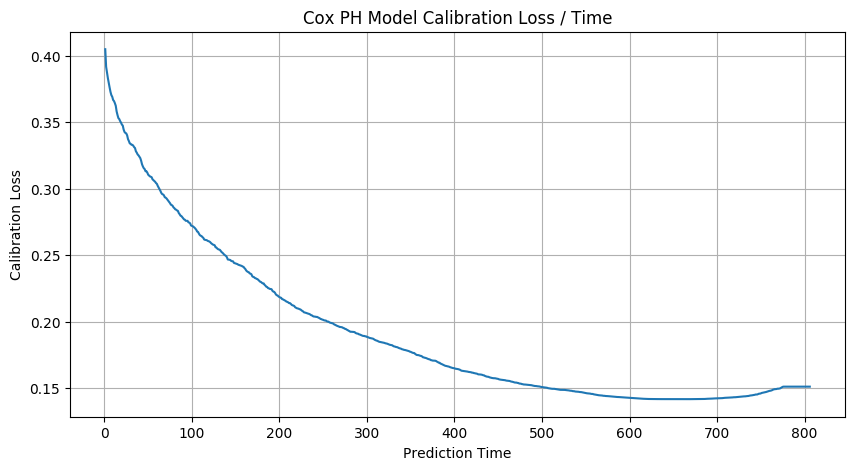

In [367]:
loss_dict = {} 
for i in cph.predict_survival_function(cph_test).index: 
    score = brier_score_loss( 
              cph_test['churn'], 1-np.array(cph.predict_survival_function(cph_test).loc[i]), pos_label=1 
          )
    loss_dict[i] = [score] 
loss_df = pd.DataFrame(loss_dict).T 

plt.figure(figsize=(5, 5))
fig, ax = plt.subplots() 
ax.plot(loss_df.index, loss_df) 
ax.set(xlabel='Prediction Time', ylabel='Calibration Loss', title='Cox PH Model Calibration Loss / Time') 
ax.grid() 

plt.show()

Text(0.5, 1.0, 'Calibration plots (reliability curve)')

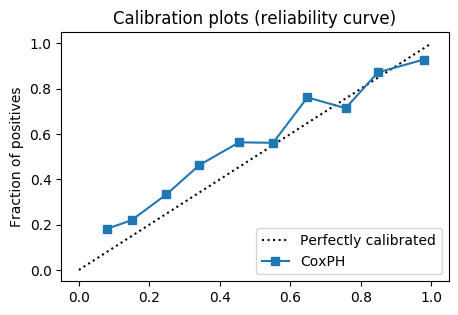

In [369]:
plt.figure(figsize=(5, 5))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated") 

probs = 1-np.array(cph.predict_survival_function(cph_test).loc[600])
actual = cph_test['churn']

fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins=10, normalize=False) 

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("CoxPH",)) 
ax1.set_ylabel("Fraction of positives") 
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve)')

In [0]:
#Estimating event time
from lifelines.utils import median_survival_times, qth_survival_times

predictions_50 = median_survival_times(conditioned_sf)
predictions_80 = qth_survival_times(0.8, conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

data['avg_value_day'] = data['monetary']/data['duration']

In [0]:
values = predictions_80.T.join(data[['avg_value_day','duration']])
#value a customer bring in the future with 80% probability to survive
values['remaining_value_80'] = values['avg_value_day'] * (values[0.8] - values['duration'])
#estimated number of days he stays with our store (future) with probability to 
values['remaining_days_80'] =  values[0.8] - values['duration']


In [374]:
values.loc[1743]

0.8                   207.000000
avg_value_day           0.536029
duration              136.000000
remaining_value_80     38.058088
remaining_days_80      71.000000
Name: 1743, dtype: float64

In [0]:
0.8                   230.000000
avg_value_day           0.536029
duration              136.000000
remaining_value_80     50.386765
remaining_days_80      94.000000
Name: 1743, dtype: float64

### References:
1. https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 - guide
2. file:///D:/Studies/UCU_MSc/!DIPLOMA/Sharable%20of%20Churn%20Analytics.pdf
3. https://bookdown.org/sestelo/sa_financial/non-proportional-hazards-and-now-what.html
4. http://dni-institute.in/blogs/cox-regression-interpret-result-and-predict/
5. https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html - documentation

